### Glacial Volume, Melt, and Net Runoff as Predicted by GLoGem

#### Loading in all Modules and Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from datetime import date
import collections
import datetime
import os

## Generic the filepath to the main data folder
fpath0 = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/GloGEM Outputs/CentralEurope/files/'
fpath = '/Users/finnwimberly/Library/CloudStorage/GoogleDrive-fwimberly@middlebury.edu/My Drive/Lizz Research Stuff/GloGEM Outputs/Runoff-intercomparison/GloGEM/Volume' 


#All of the climate models used
modelnames = ['BCC-CSM2-MR','CAMS-CSM1-0','CESM2','CESM2-WACCM','EC-Earth3','EC-Earth3-Veg','FGOALS-f3-L','GFDL-ESM4',
              'INM-CM4-8','INM-CM5-0','MPI-ESM1-2-HR','MRI-ESM2-0']

SSPpaths = ['ssp126','ssp245','ssp370','ssp585']   #Specifiying the SSP
SSPs = ['ssp119','ssp126','ssp245','ssp370','ssp585'] #Use a different path as we have all 5 ssps for volume

#### Processing Runoff Data

In [3]:
all_discharges = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_discharges = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath0 + modelname + '/' + SSPpaths[s]  + '/' + 'centraleurope_Discharge_r1.dat', sep='\s+', header=None, skiprows=1, index_col=0)
        model_discharges.append(temp_df)
    all_discharges[s] = model_discharges

In [4]:
all_areas = [[] for _ in SSPpaths]

for s, SSPpath in enumerate(SSPpaths):
    model_areas = []
    for modelname in modelnames:
        temp_df = pd.read_csv(fpath0 + modelname  + '/' + SSPpaths[s]  + '/' + 'centraleurope_Area_r1.dat', sep='\s+', index_col="ID")
        model_areas.append(temp_df)
    all_areas[s] = model_areas

In [5]:
# Create new index using pandas date_range function
start_date = datetime.date(1979, 10, 1)
end_date = datetime.date(2100, 9, 1)
new_indices = pd.date_range(start_date, end_date, freq='MS').strftime('%Y-%m').tolist()

# Apply new index and datetime conversion
for s, SSPpath_discharges in enumerate(all_discharges):
    for m, discharge_df in enumerate(SSPpath_discharges):
        all_discharges[s][m].columns = new_indices
        all_discharges[s][m].columns = pd.to_datetime(new_indices)

In [6]:
#expanding area dataset to match year-month dimension
for s in range(len(SSPpaths)):
    for i in range(len(all_areas[s])):
        all_areas[s][i] = all_areas[s][i][all_areas[s][i].columns.repeat(12)]
        
for s, areas in enumerate(all_areas):
    for i, area in enumerate(areas):
        all_areas[s][i].columns = new_indices
        all_areas[s][i].columns = pd.to_datetime(new_indices)

In [7]:
# We will use our initial area to compute runoff so we fill entire dfs with element 0
# We only use one SSP because the initial areas are all the same -- we save time without looping through all
# We also convert km^2 to m^2

initial_areas = [pd.DataFrame(df.iloc[:, 0].values.repeat(df.shape[1]).reshape(df.shape), index=df.index, columns=df.columns).mul(1e6) for df in all_areas[0]]


#### Having properly indexed our dataframes, we define the runoff of each glacier:

In [8]:
runoff = {s: {m: None for m in modelnames} for s in SSPpaths} # create nested dictionary indexed by model name and ssp
n=0
for s in SSPpaths:
    i=0
    for m in modelnames:
        runoff[s][m] = pd.concat([initial_areas[i] * all_discharges[n][i]], axis=1)
        i+=1
    n+=1

In [9]:
import itertools
annualrunoff = {s: {m: None for m in modelnames} for s in SSPpaths}
for s, m in itertools.product(SSPpaths, modelnames):
    annualrunoff[s][m] = runoff[s][m].transpose().resample('A').sum()

In [10]:
#Selecting our single glacier from the runoff dataframes
annualrunoff181 = {s: {m: annualrunoff[s][m].loc[:, 181] for m in modelnames} for s in SSPpaths}
#And calculating its rolling mean
rollingmean181 = {s: {m: annualrunoff181[s][m].rolling(30).mean() for m in modelnames} for s in SSPpaths}

In [11]:
# Setting up our color scheme
color_map = plt.colormaps['magma']
colors = {model: color_map(i/len(modelnames)) for i, model in enumerate(modelnames)}

#### Processing Volume Data:

In [12]:
#Importing the data for each SSP
all_volumes = [pd.read_csv(os.path.join(fpath, SSP, 'RGIreg11_Volume_individual.dat'), sep='\s+', header=0, skiprows=1, index_col=0) for SSP in SSPs]

In [13]:
#Creating our new index
new_indices = []
for i in range(len(all_volumes[0])):
    new_indices.append(int(((all_volumes[0].index[i]-11)*10**5))) #Here we just treat the RGI ID as a float to extract the last digits
for i in range(len(SSPs)):
    for n in range(len(all_volumes[i])):
        all_volumes[i].index = new_indices

In [14]:
#Now we have to convert ice volume to water volume and km^3 to m^3
water_volumes = [(df * 0.9 * 10**6) for df in all_volumes]

In [15]:
#Making a new data set showing the change in volume
glacial_change = []
for i, vol_df in enumerate(water_volumes):
    diff_df = vol_df.diff(axis=1)
    diff_df.drop(diff_df.columns[0], axis=1, inplace=True)  # deleting first column so we can insert diff values
    glacial_change.append(diff_df)

In [16]:
#Create dictionary indexed by ssp
glacial_runoff = {s: -df for s, df in zip(SSPs, glacial_change)}

In [17]:
annualrunoff181 = {}
volume181 = {}
for s, df in glacial_runoff.items():
    annualrunoff181[s] = df.loc[181]
    i = SSPs.index(s)
    volume181[s] = water_volumes[i].loc[181]

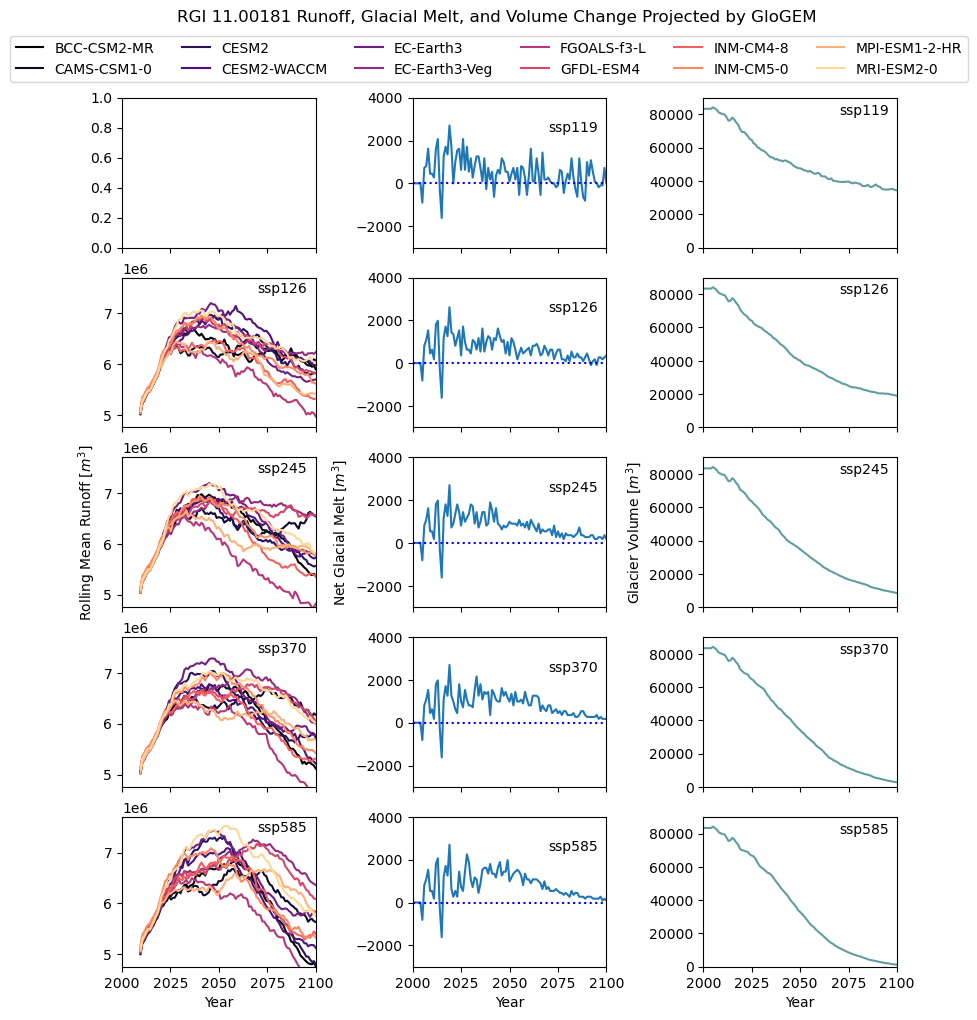

In [18]:
scenarios = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
num_models = len(modelnames)

yrs_runoff = np.linspace(1981,2100, num=122)
yrs_volume = np.linspace(1980,2100, num=121)
yrs_melt = np.linspace(1981,2100, num=120)

fig, axs = plt.subplots(len(scenarios), 3, figsize=(10, 11), sharex=True)

for i, s in enumerate(scenarios):
    # Plot the rolling mean runoff
    if s == 'ssp119':                #No data for ssp 119 for all GCM's
        continue
    axs[i, 0].set(xlim=(2000, 2100), ylim=(4.756e6, 7.7e6))
    axs[i, 0].text(2070, 7.4*10**6, s)
    axs[i, 0].axhline(y=0, linestyle=':', color='b')
    for m in modelnames:
        axs[i, 0].plot(yrs_runoff, rollingmean181[s][m], label=m, c=colors[m])
        
for i, s in enumerate(scenarios):    #Have to include this due to the continue statement above
    # Plot the annual glacial melt
    axs[i, 1].plot(yrs_melt, annualrunoff181[s])
    axs[i, 1].set_ylim(-3000, 4000)
    axs[i, 1].text(2070, 2400, s)
    axs[i, 1].axhline(y=0, linestyle=':', color='b')

    # Plot the volume
    axs[i, 2].plot(yrs_volume, volume181[s], color='cadetblue')
    axs[i, 2].set_ylim(0, 9*10**4)
    axs[i, 2].text(2070, 8*10**4, s)
    
    #Setting x labels
    if i == 4:
        axs[i, 0].set_xlabel('Year')
        axs[i, 1].set_xlabel('Year')
        axs[i, 2].set_xlabel('Year')
    #Setting y labels
    if i == 2:
        axs[i, 0].set_ylabel(r'Rolling Mean Runoff $[m^3]$')
        axs[i, 1].set_ylabel(r'Net Glacial Melt $[m^3]$')
        axs[i, 2].set_ylabel(r'Glacier Volume $[m^3]$')
        
plt.subplots_adjust(top=.9, wspace=0.5, hspace=0.2)
plt.suptitle('RGI 11.00181 Runoff, Glacial Melt, and Volume Change Projected by GloGEM')
axs[i, 0].legend(bbox_to_anchor=(4.4, 6.26), ncol=6)

plt.show()